In [1]:
import numpy as np
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt

In [2]:
def input_data_from_code():
    N = 100
    a = [0.08, 0.25, -0.25, -0.19]
    b = [0.7, 0.2, 0.1]
    p = 3
    q = 3
    return N, a, b, p, q

In [3]:
def v_from_txt():
    v = np.loadtxt(
        'v.txt'
    )
    return v

def y_from_txt():
    y = np.loadtxt(
        'y.txt'
    )
    return y

def coef_from_txt():
    coef = np.loadtxt(
        'test.txt',
        dtype = 'str'
    )
    return coef

In [4]:
def generating_epsilon(N, error=1e-3):
    epsilon = np.array([])
    epsilon = uniform(loc=-error, scale=2 * error).rvs(size=N)
    return epsilon


In [5]:
def generating_v(N):
    v = np.array([])
    v = norm(loc=0, scale=1).rvs(size=N)
    return v


In [6]:
def generating_y(v, epsilon, N, a, b, p, q):
    y = np.array([])

    for m in range(0, max(p, q)):
        y = np.append(y, v[m])

    for i in range(max(p, q), N):
        summ = a[0]
        for autoregressive in range(1, p + 1):
            summ += a[autoregressive] * y[i - autoregressive]
        for moving_average in range(0, q):
            summ += b[moving_average] * v[i - moving_average - 1]
        summ += v[i]
        summ += epsilon[i]
        y = np.append(y, summ)
    return y


In [7]:
def create_matrix_x(y, v, N, p, q):
    x = np.array([[1] * (N - max(p, q))])
    for i in range(1, p + 1):
        x_column = np.array([])
        for k in range(max(p, q), N):
            x_column = np.append(x_column, y[k - i])
        x = np.append(x, [x_column], axis=0)
    for j in range(0, q + 1):
        x_column = np.array([])
        for k in range(max(p, q), N):
            x_column = np.append(x_column, v[k - j])
        x = np.append(x, [x_column], axis=0)

    return x.transpose()


In [8]:
def create_teta(a, b, p, q):
    teta = np.array([])
    for i in range(0, p + 1):
        teta = np.append(teta, a[i])
    teta = np.append(teta, 1.)
    for i in range(0, q):
        teta = np.append(teta, b[i])

    return teta


In [9]:
def resize_y(y, p):
    return y[p:]


In [10]:
def mnk(x, y):
    
    global a0s_mnk
    global a1s_mnk
    global a2s_mnk
    global a3s_mnk
    global b1s_mnk
    global b2s_mnk
    global b3s_mnk
    
    x_t = x.transpose()
    res = np.linalg.inv(x_t @ x) @ x_t @ y
    if x[0].size > 7:
        a0s_mnk = np.append(a0s_mnk, res[0])
        a1s_mnk = np.append(a1s_mnk, res[1])
        a2s_mnk = np.append(a2s_mnk, res[2])
        a3s_mnk = np.append(a3s_mnk, res[3])
        b1s_mnk = np.append(b1s_mnk, res[5])
        b2s_mnk = np.append(b2s_mnk, res[6])
        b3s_mnk = np.append(b3s_mnk, res[7])
    
    return res


In [11]:
def rmnk(x, y):
    teta_0 = np.array([[0] * (len(x[0]))]).transpose()
    beta = 10
    p_0 = np.eye(len(x[0])) * beta
    
    global a0s_rmnk
    a0s_rmnk = np.array([])
    global a1s_rmnk
    a1s_rmnk = np.array([])
    global a2s_rmnk
    a2s_rmnk = np.array([])
    global a3s_rmnk
    a3s_rmnk = np.array([])
    global b1s_rmnk
    b1s_rmnk = np.array([])
    global b2s_rmnk
    b2s_rmnk = np.array([])
    global b3s_rmnk
    b3s_rmnk = np.array([])
    
    for i in range(len(x)):
        x_m = x[i].reshape(1, -1)
        x_m_t = x[i].reshape(-1, 1)
        p_1 = p_0 - (p_0.dot(x_m_t.dot(x_m.dot(p_0)))) / (1 + x_m.dot(p_0.dot(x_m_t)))
        teta_1 = teta_0 + p_1.dot(x_m_t) * (y[i] - x_m.dot(teta_0))
        teta_0 = teta_1
        p_0 = p_1
        if x[0].size > 7:
            a0s_rmnk = np.append(a0s_rmnk, teta_0[0][0])
            a1s_rmnk = np.append(a1s_rmnk, teta_0[1][0])
            a2s_rmnk = np.append(a2s_rmnk, teta_0[2][0])
            a3s_rmnk = np.append(a3s_rmnk, teta_0[3][0])
            b1s_rmnk = np.append(b1s_rmnk, teta_0[5][0])
            b2s_rmnk = np.append(b2s_rmnk, teta_0[6][0])
            b3s_rmnk = np.append(b3s_rmnk, teta_0[7][0])

    return teta_0


In [12]:
def summ_squares_errors(y, y_1):
    error = np.linalg.norm(y_1 - y) ** 2
    return error


In [13]:
def r_2(y, y_1):
    return np.var(y_1) / np.var(y)


In [14]:
def calculation_of_the_Akaike_criterion(s, p, q, N):
    n = p + q + 1
    return N * np.log(s) + 2 * n


In [15]:
if __name__ == '__main__':
    ### use this to generate series v and y and see the comparison results for 9 equations
    N, a, b, p, q = input_data_from_code()
    v = generating_v(N)
    flag = False
    
    ### use this to read v and y from file and see the specific result for those series
#     v = v_from_txt()
#     y = y_from_txt()
#     coef = coef_from_txt()
#     a = [float(c[3:]) for c in coef if c[0]=='a']
#     b = [float(c[3:]) for c in coef if c[0]=='b']
#     p = len(a) - 1
#     q = len(b)
#     N = len(v)
#     flag = True
    
    epsilon = generating_epsilon(N)
    

    s_mnk = np.array([])
    s_rmnk = np.array([])
    r_2_mnk = np.array([])
    r_2_rmnk = np.array([])
    ika_mnk = np.array([])
    ika_rmnk = np.array([])
    
    a0s_mnk = np.array([])
    a0s_rmnk = np.array([])
    a1s_mnk = np.array([])
    a1s_rmnk = np.array([])
    a2s_mnk = np.array([])
    a2s_rmnk = np.array([])
    a3s_mnk = np.array([])
    a3s_rmnk = np.array([])
    b1s_mnk = np.array([])
    b1s_rmnk = np.array([])
    b2s_mnk = np.array([])
    b2s_rmnk = np.array([])
    b3s_mnk = np.array([])
    b3s_rmnk = np.array([])
    counter = 0
    
    if flag == False: 
        for i in range(3):
            for j in range(3):
                p = i + 1
                q = j + 1
                print("АРКС(" + str(p) + ", " + str(q) + ")")
                y = generating_y(v, epsilon, N, a, b, p, q)
                x = create_matrix_x(y, v, N, p, q)
                res_mnk = mnk(x, resize_y(y, max(p, q)))
                if p+q == 6:
                    for k in range(p+1, x.T[0].size):
                        res_mnk = mnk(x[:k], resize_y(y[:k+3], max(p, q)))

                res_rmnk = rmnk(x, resize_y(y, max(p, q)))

                y_s_krushkoy_mnk = x @ res_mnk
                y_s_krushkoy_rmnk = x @ res_rmnk
                s_mnk = np.append(s_mnk, summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_mnk))
                s_rmnk = np.append(s_rmnk, summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()))
                r_2_mnk = np.append(r_2_mnk, r_2(resize_y(y, max(p, q)), y_s_krushkoy_mnk))
                r_2_rmnk = np.append(r_2_rmnk, r_2(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()))
                ika_mnk = np.append(ika_mnk,
                                    calculation_of_the_Akaike_criterion(
                                        summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_mnk), p, q, N - max(p, q)))
                ika_rmnk = np.append(ika_rmnk,
                                     calculation_of_the_Akaike_criterion(
                                         summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()), p, q, N - max(p, q)))
                print("s_mnk = {}, s_rmnk = {}, r_2_mnk = {}, r_2_rmnk = {}, ika_mnk = {}, ika_rmnk = {}".format(s_mnk[counter], s_rmnk[counter], r_2_mnk[counter], r_2_rmnk[counter], ika_mnk[counter], ika_rmnk[counter]))
                print("")
                counter += 1
    else:
        print("АРКС(" + str(p) + ", " + str(q) + ")")
        x = create_matrix_x(y, v, N, p, q)
        res_mnk = mnk(x, resize_y(y, max(p, q)))
        if p+q == 6:
            for k in range(p+1, x.T[0].size):
                res_mnk = mnk(x[:k], resize_y(y[:k+3], max(p, q)))

        res_rmnk = rmnk(x, resize_y(y, max(p, q)))

        y_s_krushkoy_mnk = x @ res_mnk
        y_s_krushkoy_rmnk = x @ res_rmnk
        s_mnk = np.append(s_mnk, summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_mnk))
        s_rmnk = np.append(s_rmnk, summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()))
        r_2_mnk = np.append(r_2_mnk, r_2(resize_y(y, max(p, q)), y_s_krushkoy_mnk))
        r_2_rmnk = np.append(r_2_rmnk, r_2(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()))
        ika_mnk = np.append(ika_mnk,
                            calculation_of_the_Akaike_criterion(
                                summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_mnk), p, q, N - max(p, q)))
        ika_rmnk = np.append(ika_rmnk,
                                calculation_of_the_Akaike_criterion(
                                    summ_squares_errors(resize_y(y, max(p, q)), y_s_krushkoy_rmnk.transpose()), p, q, N - max(p, q)))
        print("s_mnk = {}, s_rmnk = {}, r_2_mnk = {}, r_2_rmnk = {}, ika_mnk = {}, ika_rmnk = {}".format(s_mnk[counter], s_rmnk[counter], r_2_mnk[counter], r_2_rmnk[counter], ika_mnk[counter], ika_rmnk[counter]))
        print("")
        print("coef in mnk = {}".format(res_mnk))
        print("coef in rmnk = {}".format(res_rmnk.reshape(1, res_rmnk.size)))

АРКС(1, 1)
s_mnk = 3.2952024735721296e-05, s_rmnk = 0.000246868235261101, r_2_mnk = 0.9999997262686303, r_2_rmnk = 0.9974624721395139, ika_mnk = -1015.725327166988, ika_rmnk = -816.3589265916752

АРКС(1, 2)
s_mnk = 3.26256062354999e-05, s_rmnk = 0.0005518195521481235, r_2_mnk = 0.9999997257030886, r_2_rmnk = 0.9973747546104579, ika_mnk = -1004.3804848351766, ika_rmnk = -727.2243674144205

АРКС(1, 3)
s_mnk = 3.1839809022323856e-05, s_rmnk = 0.0017048622786197615, r_2_mnk = 0.9999997327762737, r_2_rmnk = 0.9973930884564217, ika_mnk = -994.4149399197213, ika_rmnk = -608.304281811684

АРКС(2, 1)
s_mnk = 3.256426244955268e-05, s_rmnk = 0.00024756993900285263, r_2_mnk = 0.9999997581423675, r_2_rmnk = 0.9976293961953331, ika_mnk = -1004.564921248948, ika_rmnk = -805.7741085363656

АРКС(2, 2)
s_mnk = 3.198398304463645e-05, s_rmnk = 0.0008629801629202076, r_2_mnk = 0.9999997445933213, r_2_rmnk = 0.9974055494752354, ika_mnk = -1004.326980412001, ika_rmnk = -681.4016476265859

АРКС(2, 3)
s_mnk = 

S for MNK


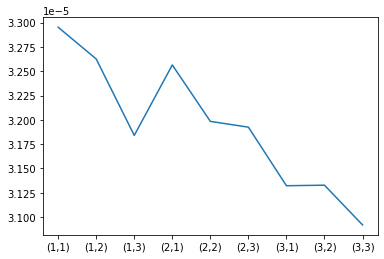

R2 for MNK


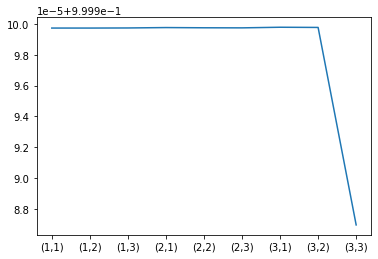

IKA for MNK


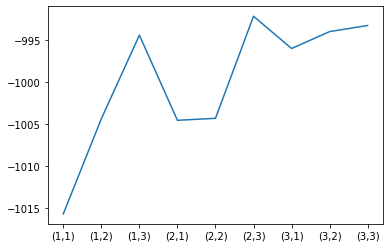

S for RMNK


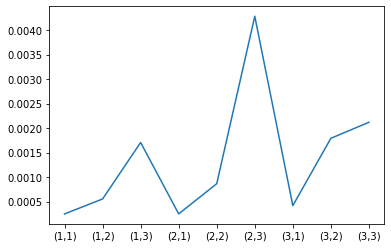

R2 for RMNK


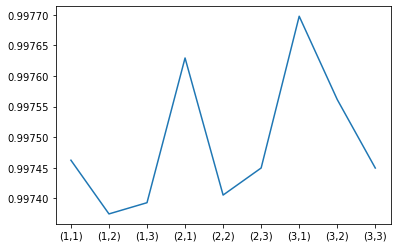

IKA for RMNK


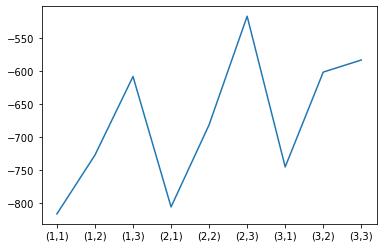

In [16]:
if flag == False:
    print("S for MNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), s_mnk)
    plt.show()
    print("R2 for MNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), r_2_mnk)
    plt.show()
    print("IKA for MNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), ika_mnk)
    plt.show()
    print("S for RMNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), s_rmnk)
    plt.show()
    print("R2 for RMNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), r_2_rmnk)
    plt.show()
    print("IKA for RMNK")
    plt.plot(("(1,1)", "(1,2)", "(1,3)", "(2,1)", "(2,2)", "(2,3)", "(3,1)", "(3,2)", "(3,3)"), ika_rmnk)
    plt.show()

a0 in (3,3)


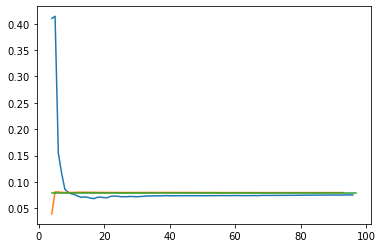

In [17]:
print("a0 in (3,3)")
plt.plot(range(4, a0s_rmnk.size), a0s_rmnk[4:])
plt.plot(range(4, a0s_mnk.size), a0s_mnk[4:])
plt.plot([4, a0s_rmnk.size], [a[0], a[0]])
plt.show()

a1 in (3,3)


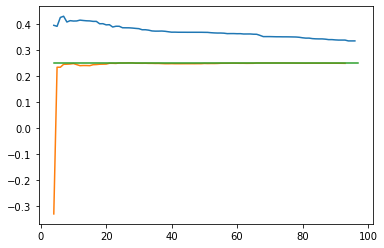

In [18]:
print("a1 in (3,3)")
plt.plot(range(4, a1s_rmnk.size), a1s_rmnk[4:])
plt.plot(range(4, a1s_mnk.size), a1s_mnk[4:])
plt.plot([4, a1s_rmnk.size], [a[1], a[1]])
plt.show()

a2 in (3,3)


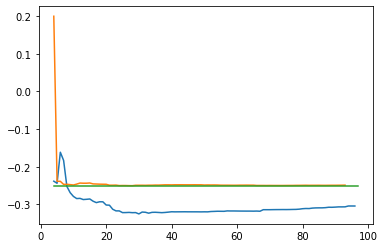

In [19]:
print("a2 in (3,3)")
plt.plot(range(4, a2s_rmnk.size), a2s_rmnk[4:])
plt.plot(range(4, a2s_mnk.size), a2s_mnk[4:])
plt.plot([4, a2s_rmnk.size], [a[2], a[2]])
plt.show()

a3 in (3,3)


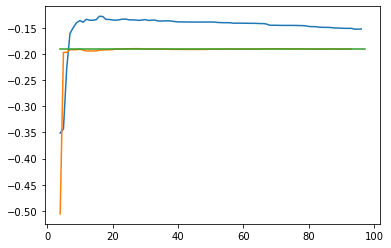

In [20]:
print("a3 in (3,3)")
plt.plot(range(4, a3s_rmnk.size), a3s_rmnk[4:])
plt.plot(range(4, a3s_mnk.size), a3s_mnk[4:])
plt.plot([4, a3s_rmnk.size], [a[3], a[3]])
plt.show()

b1 in (3,3)


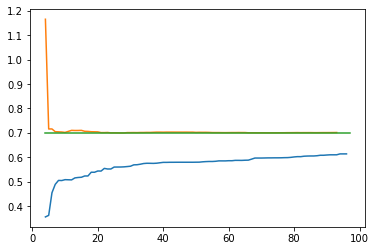

In [21]:
print("b1 in (3,3)")
plt.plot(range(4, b1s_rmnk.size), b1s_rmnk[4:])
plt.plot(range(4, b1s_mnk.size), b1s_mnk[4:])
plt.plot([4, b1s_rmnk.size], [b[0], b[0]])
plt.show()

b2 in (3,3)


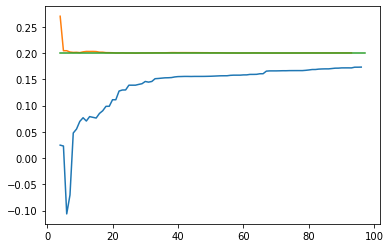

In [22]:
print("b2 in (3,3)")
plt.plot(range(4, b2s_rmnk.size), b2s_rmnk[4:])
plt.plot(range(4, b2s_mnk.size), b2s_mnk[4:])
plt.plot([4, b2s_rmnk.size], [b[1], b[1]])
plt.show()

b3 in (3,3)


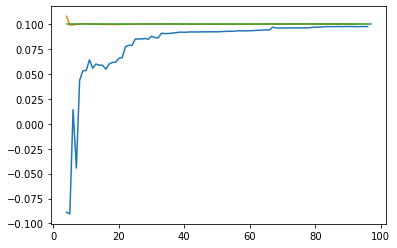

In [23]:
print("b3 in (3,3)")
plt.plot(range(4, b3s_rmnk.size), b3s_rmnk[4:])
plt.plot(range(4, b3s_mnk.size), b3s_mnk[4:])
plt.plot([4, b3s_rmnk.size], [b[2], b[2]])
plt.show()